In [1]:
# from utils_torsion_dataset_generator import *
from util_2nd_round_generator import *

RDKit WARNING: [09:27:03] Enabling RDKit 2019.09.3 jupyter extensions
Failed to import the evaluator package.


In [3]:
%%capture cap1 --no-stderr
# Create force field object
forcefield = ForceField('param_valence.offxml', allow_cosmetic_attributes=True)

# Create dictionaries storing molecules and attributes 
molecules_list_dict, molecule_attributes = read_aggregate_molecules("bayer_optimization_inputs.json")

# List torsion parameters and effective rotations matched to each parameter from input molecule set
tid_molecules_list = gen_tid_molecules_list(molecule_attributes, molecules_list_dict, forcefield )




Warning (not error because allow_undefined_stereo=True): OEMol has unspecified stereochemistry. oemol.GetTitle(): 
Problematic atoms are:
Atom atomic num: 16, name: , idx: 11, aromatic: False, chiral: True with bonds:
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 6, aromatic: True, chiral: False
bond order: 1, chiral: False to atom atomic num: 6, name: , idx: 5, aromatic: False, chiral: False
bond order: 2, chiral: False to atom atomic num: 8, name: , idx: 9, aromatic: False, chiral: False



In [4]:

# Read pickle file containing data downloaded from qcarchive for reuse
gen2_torsiondrive_data = download_torsiondrive_data('OpenFF Gen 2 Torsion Set 5 Bayer', output_pickle='bayer_gen2_torsiondrive_data.pickle')
# List up pre-calculated torsions for re-use
gen2_tid_calculated_molecules_list, gen2_molecules_list_dict_from_td = gen_tid_calculated_molecules_list(gen2_torsiondrive_data, forcefield)   

Loading TorsionDrive Scans from [ OpenFF Gen 2 Torsion Set 5 Bayer ] spec [default]
Found 100 data entries
Found 100 torsiondrive records
    1 : [CH3:1][C:2](C)([C:3](Cn1cncn1)(Cn2cncn2)[OH:4])Oc3ccc(cc3)Cl status COMPLETE
    2 : [CH3:1][C@@H:2]([C@H:3]([CH2:4]N1CCN(CC1)c2ccccc2)O)Oc3cc(ccc3OC)[C@H]4CC(=O)NC4 status ERROR
    3 : [H:1][CH2:2][CH:3]([H:4])OC(=O)C[N@@](CCO)Cc1ccccc1 status COMPLETE
    4 : [H:4][C@:3]([C@H](n1ccnc1)Oc2ccccc2)([C:2](C)([CH3:1])C)O status COMPLETE
    5 : CC[O:4][CH2:3][CH2:2][O:1]c1cc(c(cc1C#N)F)N2C(=O)[C@@H]3CCCCN3C2=O status COMPLETE
    6 : [H:4][CH2:3][C@H:2](C1CCCCC1)[O:1]c2cc(c(cc2C(=O)NCCN(C)C)F)n3c(=O)n4c(n3)CCCC4 status ERROR
    7 : [H:4][CH2:3][C:2](C)(Cn1c(=O)c2c(c(sc2n(c1=O)CCC(F)(F)F)CN3CCNC3=O)C)[F:1] status COMPLETE
    8 : [H:4][C@:3]([C@@H](C(=O)C1(CC1)C)n2cncn2)([C:2](CCC)(Cl)[Cl:1])O status RUNNING
    9 : Cc1cc[c:1](cc1)[C:2]2(CC2)[CH2:3][n:4]3c(=O)n4c(n3)CCC[C@@H]4C(=O)N5CCC(C5)(F)F status COMPLETE
   10 : [CH3:4][C:3]1([C@@H:2]([C

In [5]:
%%capture cap2 --no-stderr

# clustering each list of molecules and tid_molecules_list -> tid_clusters_list
# output: `tid_clusters_list[tid] = [..., {'cluster_label': N, 'torsions': [...]}, ...] `
tid_clusters_list = gen_tid_clusters_list_mod(tid_molecules_list, fptype=OEFPType_MACCS166)

In [6]:
# find if any cluster has pre-calculated torsion and add one more information 'reusable' in the dictionary 
# if 'reusable' == False, no reusable torsion detacted
# tid_clusters_list_detailed[tid] = [ {'cluster_label': N, 'torsions': [...], 'reusable': False or torsion_info}, ...]
tid_clusters_list_detailed = find_reusable_cluster(tid_clusters_list, gen2_tid_calculated_molecules_list)

In [7]:
# Convert linear dependency (data degenracy) into graph representaion
graph_reusable_set, graph_single_coverage_set, graph_multiple_coverage_sets = gen_graph_for_2nd_round(tid_clusters_list_detailed)

In [8]:
# randomized optimization procedure for minimization of data-degeneracy
selected , final_coverage, final_overlap, coverage_history, overlap_history = find_minimum_degeneracy_for_2nd_round(graph_reusable_set, graph_single_coverage_set, graph_multiple_coverage_sets)

In [9]:
%%capture cap3 --no-stderr

selected_rotations, molecules_list_dict_updated = select_rotations_for_2nd_round(tid_clusters_list_detailed, selected, molecules_list_dict,  tid_calculated_molecules_list=None, molecules_list_dict_from_td=None, first_round_tid_calculated_molecules_list=gen2_tid_calculated_molecules_list, first_round_molecules_list_dict_from_td=gen2_molecules_list_dict_from_td)

# Store selected molecules into json file
gen_json_for_2nd_round(selected_rotations, molecule_attributes, molecules_list_dict_updated, output_json='roche_2_selected_torsions.json')


In [10]:

with open('select.log', 'w') as f:
    f.write(cap1.stdout)
    f.write(cap2.stdout)
    f.write(cap3.stdout)

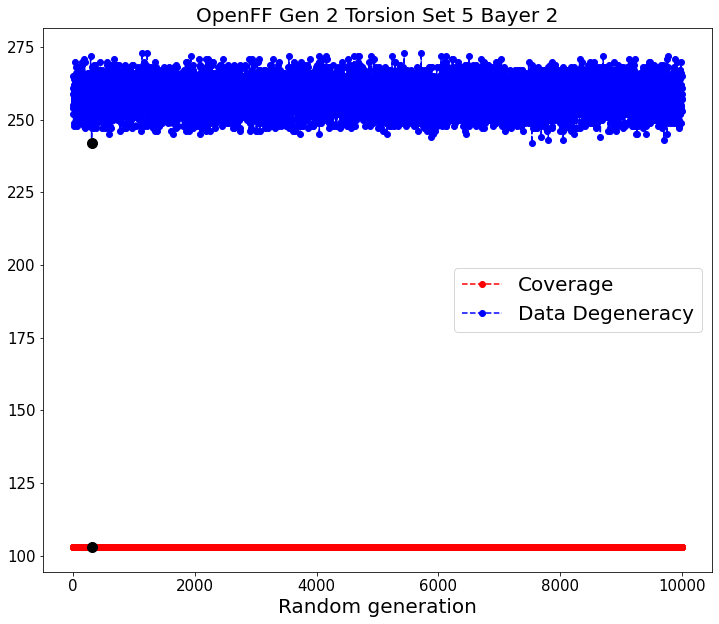

In [11]:
plt.figure(figsize=(12,10))
plt.plot(range(len(coverage_history)), coverage_history,'ro--', label='Coverage')
plt.scatter([overlap_history.index(final_overlap)], [final_coverage],c='k', s=100,zorder=10)
plt.plot(range(len(overlap_history)), overlap_history, 'bo--', label='Data Degeneracy')
plt.scatter([overlap_history.index(final_overlap)], [final_overlap],c='k', s=100,zorder=10)

plt.xlabel('Random generation', fontdict = {'fontsize' : 20})
plt.title('OpenFF Gen 2 Torsion Set 5 Bayer 2', fontdict = {'fontsize' : 20})
plt.legend(prop={'size': 20})
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()